# FCC Security Recommendations: NLP Model

In [1]:
# Imports!
# We likely will not end up using all of these, but better to have & not need.

import pickle       # Imports pickle if we want to save the model for later
import regex as re  # Imports Regex
import pandas as pd # Imports Pandas
import numpy as np  # Imports NumPy
import scipy as sp  # Imports SciPy
import seaborn as sns # Imports Seaborn
import gensim

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.metrics import r2_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# Loads in the csv file through the Pandas library & allows us to view it.
fcc_csv = pd.read_csv('./data/CSRIC_Best_Practices.csv')

## Exploratory Analysis & Data Cleaning

In [3]:
# Here's a function to convert NaN's in the data set to 'None' for string objects.
# Just pass in the entire data frame.
def convert_str_nan(data):
    return data.replace(np.nan, 'None', inplace = True)
convert_str_nan(fcc_csv)

# Here's a function to drop any rows with NaN's in the dataset.
# Just pass in the entire data frame.
def drop_nans(data):
    return data.dropna()
drop_nans(fcc_csv).head()

,BP Number,Priority,Description,Network Type(s),Industry Role(s),Keywords,Reference,cable,internet/Data,satellite,wireless,wireline,Service Provider,Network Operator,"Priority (1,2,3)",Equipment Supplier,Property Manager,Government,Public Safety
0,11-10-0404,Important,"Service Providers, Network Operators, Public S...",Cable; Internet/Data; Satellite; Wireless; Wir...,Equipment Supplier; Network Operator; Service ...,Hardware; Network Design; Network Elements; Ne...,None,True,True,True,True,True,True,True,1,True,False,False,True
1,11-10-0407,Highly Important,Network Operators and Service Providers should...,Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider;,Industry Cooperation; Network Interoperability...,None,True,True,True,True,True,True,True,2,False,False,False,False
2,11-10-0409,Highly Important,Service Providers should use virtual interface...,Internet/Data;,Service Provider;,Network Design; Network Elements;,None,False,True,False,False,False,True,False,2,False,False,False,False
3,11-10-0411,Highly Important,"Network Operators, Service Providers, and Publ...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Facilities - Transport;,None,True,True,True,True,True,True,True,2,False,False,False,True
4,11-10-0418,Highly Important,"Network Operators, Service Providers, and Publ...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Procedures;,Note: This Best practice could impact 9-1-1 op...,True,True,True,True,True,True,True,2,False,False,False,True


In [4]:
# Gives us a list of all the column names within the data frame.
fcc_csv.columns

Index(['BP Number', 'Priority', 'Description', 'Network Type(s)',
       'Industry Role(s)', 'Keywords', 'Reference', 'cable', 'internet/Data',
       'satellite', 'wireless', 'wireline', 'Service Provider',
       'Network Operator', 'Priority (1,2,3)', 'Equipment Supplier',
       'Property Manager', 'Government', 'Public Safety'],
      dtype='object')

In [5]:
# Let's rename the 'Priority (1,2,3)' column so we can utilize it.
fcc_csv.rename(columns = {
    'Priority (1,2,3)': 'Priorities'
},
inplace = True)

# Let's view the values & how the correspond to the 'Priority' column.
fcc_csv['Priorities'].value_counts()

1    468
2    356
3    192
Name: Priorities, dtype: int64

## Preprocessing, Tokenization, Lemmatization, Stemming & Word Count Visualization

### Preprocessing

In [6]:
# This is a text preprocessing function that gets our data ready for modeling & creates new columns for the 
    # description text in their tokenized, lemmatized & stemmed forms. This allows for easy selection of 
    # different forms of the text for use in vectorization & modeling.

def preprocessed_columns(dataframe = fcc_csv, 
                        column = 'Description', 
                        new_lemma_column = 'lemmatized', 
                        new_stem_column = 'stemmed',
                        new_token_column = 'tokenized',
                        regular_expression = r'\w+'): 
    
    tokenizer = RegexpTokenizer(regular_expression)      # Instantiate tokenizer w/ specific regular expression
    lemmatizer = WordNetLemmatizer()                     # Instantiate lemmatizer
    stemmer = PorterStemmer()                            # Instantiate stemmer
    
    lemmatized = []                                      # List to append lemmatized data
    stemmed = []                                         # List to append stemmed words
    tokenized = []
    
    
    for i in dataframe[column]:                          # Iterate through all rows in a specific column

        tokens = tokenizer.tokenize(i.lower())           # Converts string titles to tokens 
        tokenized.append(tokens)

        lemma = [lemmatizer.lemmatize(token) for token in tokens]     # Lemmatizes all tokens
        lemmatized.append(lemma)                                      # Appends the lemma to a lemmatized list

        stems = [stemmer.stem(token) for token in tokens]             # Stemming all tokens
        stemmed.append(stems)                                         # Creating stem list
     
    dataframe[new_token_column] = [' '.join(i) for i in tokenized]    
    dataframe[new_lemma_column] = [' '.join(i) for i in lemmatized]   # Rejoing the lists for each title
    dataframe[new_stem_column] = [' '.join(i) for i in stemmed]       # Setting results to be new columns in df   
    
    return dataframe

In [7]:
processed = preprocessed_columns()
processed.head()

,BP Number,Priority,Description,Network Type(s),Industry Role(s),Keywords,Reference,cable,internet/Data,satellite,...,Service Provider,Network Operator,Priorities,Equipment Supplier,Property Manager,Government,Public Safety,tokenized,lemmatized,stemmed
0,11-10-0404,Important,"Service Providers, Network Operators, Public S...",Cable; Internet/Data; Satellite; Wireless; Wir...,Equipment Supplier; Network Operator; Service ...,Hardware; Network Design; Network Elements; Ne...,None,True,True,True,...,True,True,1,True,False,False,True,service providers network operators public saf...,service provider network operator public safet...,servic provid network oper public safeti and e...
1,11-10-0407,Highly Important,Network Operators and Service Providers should...,Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider;,Industry Cooperation; Network Interoperability...,None,True,True,True,...,True,True,2,False,False,False,False,network operators and service providers should...,network operator and service provider should e...,network oper and servic provid should establis...
2,11-10-0409,Highly Important,Service Providers should use virtual interface...,Internet/Data;,Service Provider;,Network Design; Network Elements;,None,False,True,False,...,True,False,2,False,False,False,False,service providers should use virtual interface...,service provider should use virtual interface ...,servic provid should use virtual interfac i e ...
3,11-10-0411,Highly Important,"Network Operators, Service Providers, and Publ...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Facilities - Transport;,None,True,True,True,...,True,True,2,False,False,False,True,network operators service providers and public...,network operator service provider and public s...,network oper servic provid and public safeti s...
4,11-10-0418,Highly Important,"Network Operators, Service Providers, and Publ...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Procedures;,Note: This Best practice could impact 9-1-1 op...,True,True,True,...,True,True,2,False,False,False,True,network operators service providers and public...,network operator service provider and public s...,network oper servic provid and public safeti s...


In [8]:
# We notice that we have an unbalanced classification problem.
# Let's group the "Highly Important" (2) & "Critical" (3) aspects because that's where we can make recommendations.
# Let's double check that it worked.
fcc_csv['Priorities'] = [0 if i == 1 else 1 for i in fcc_csv['Priorities']]
fcc_csv['Priorities'].value_counts()

1    548
0    468
Name: Priorities, dtype: int64

### Tokenization

In [9]:
# Instantiate a CountVectorizer removing english stopwords, ngram range of unigrams & bigrams.

cv = CountVectorizer(stop_words = 'english', ngram_range = (1,2), min_df = 25, max_df = .95)

# Create a dataframe of our CV transformed tokenized words
cv_df_token = pd.SparseDataFrame(cv.fit_transform(processed['tokenized']), columns = cv.get_feature_names())
cv_df_token.fillna(0, inplace = True)

cv_df_token.head()

,access,access control,address,analysis,applications,appropriate,associated,authentication,available,based,...,traffic,unauthorized,use,used,user,users,using,vulnerabilities,wireless,work
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


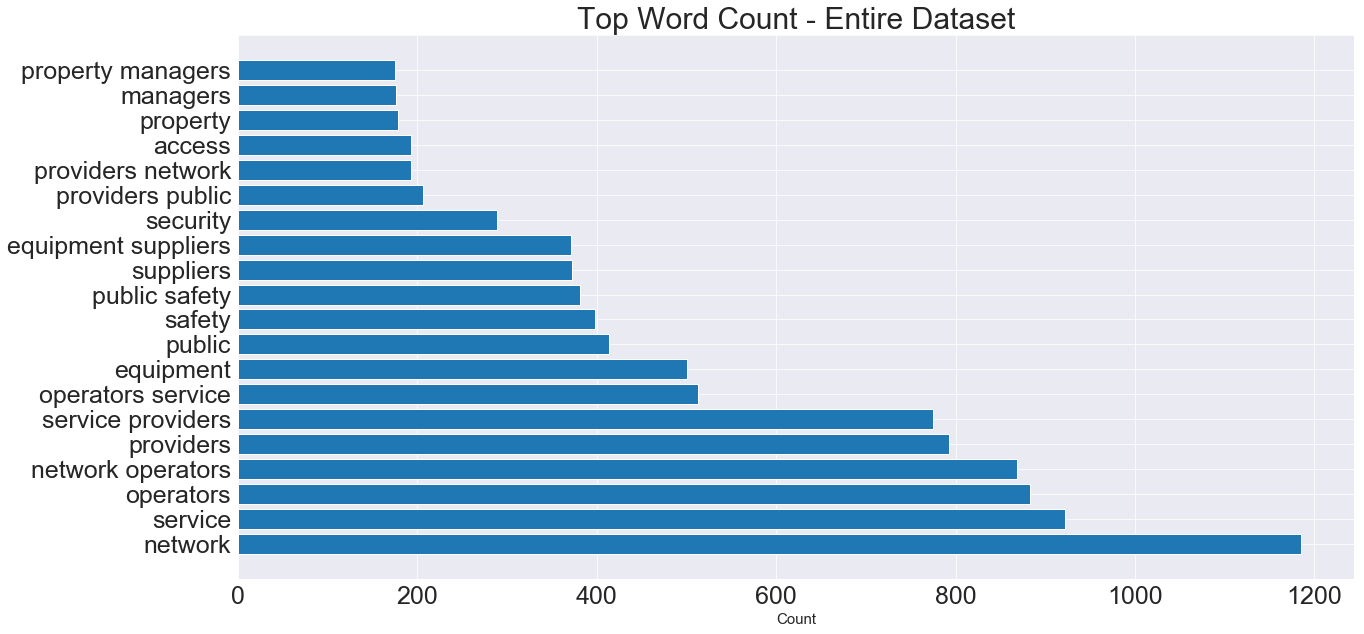

In [10]:
# Visualize the top occurring words in our descriptions column correlation to the priority.
plt.figure(figsize = (20, 10))
plt.barh(y = cv_df_token.sum().sort_values(ascending = False).head(20).index, width = cv_df_token.sum().sort_values(ascending = False).head(20))
plt.title('Top Word Count - Entire Dataset', fontsize = 30)
plt.xlabel('Count', fontsize = 15)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25);

In [11]:
# Split our data frame into really "important" & "not important" columns.
# We will use the "really_important" descriptions to determine severity & to give recommendations/analysis.
fcc_really_important = processed[processed['Priorities'] == 1]
fcc_not_important = processed[processed['Priorities'] == 0]

print(fcc_really_important.shape)
print(fcc_not_important.shape)

(548, 22)
(468, 22)


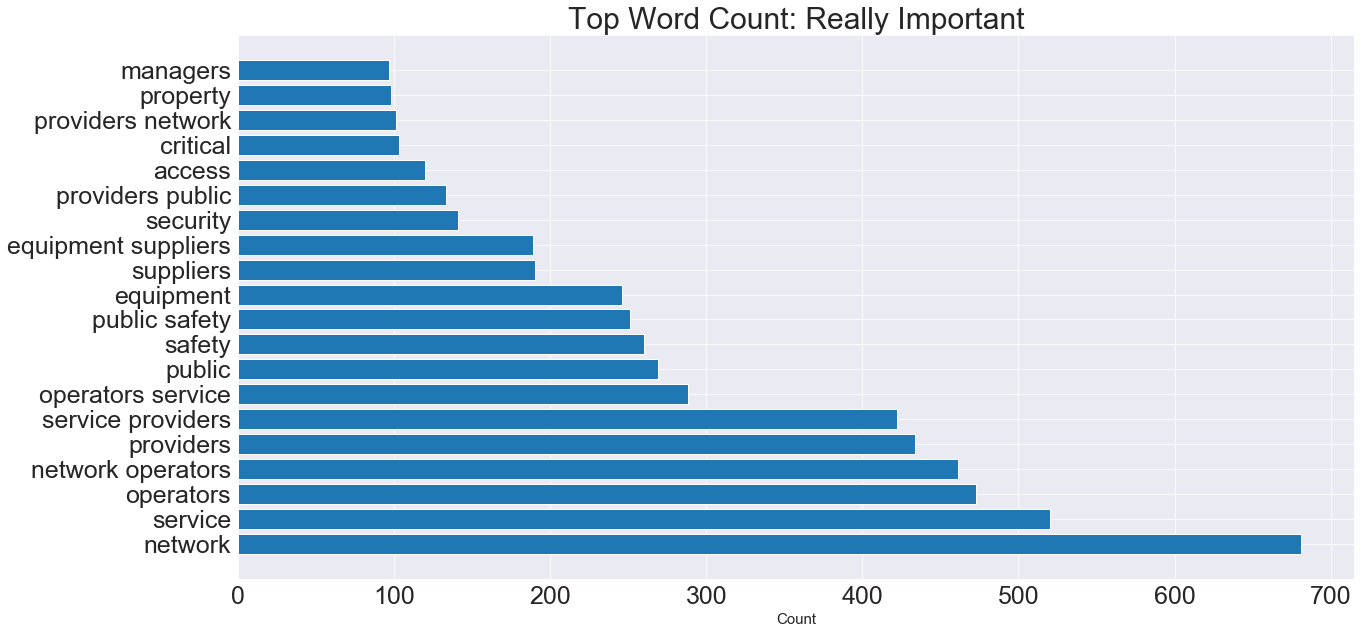

In [12]:
# Create our dataframe of features obtained from our CountVectorizer.
cv_fcc_really_important_token = pd.SparseDataFrame(cv.fit_transform(fcc_really_important['tokenized']), columns = cv.get_feature_names())
cv_fcc_really_important_token.fillna(0, inplace = True)

# Plot top 20 "really_important" features.
plt.figure(figsize = (20, 10))
plt.barh(y = cv_fcc_really_important_token.sum().sort_values(ascending = False).head(20).index, width = cv_fcc_really_important_token.sum().sort_values(ascending = False).head(20))
plt.title('Top Word Count: Really Important', fontsize = 30)
plt.xlabel('Count', fontsize = 15)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25);

### Lemmatization

In [13]:
# This is the same thing we did above but for lemmatized words rather than tokenized words.
cv_lem = CountVectorizer(stop_words = 'english', ngram_range = (1,2), min_df = 25, max_df = .95)

cv_df_lem = pd.SparseDataFrame(cv_lem.fit_transform(processed['lemmatized']), columns = cv_lem.get_feature_names())
cv_df_lem.fillna(0, inplace = True)
cv_df_lem.head()

,access,access control,activity,address,analysis,application,appropriate,area,associated,attack,...,time,traffic,unauthorized,use,used,user,using,vulnerability,wireless,work
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


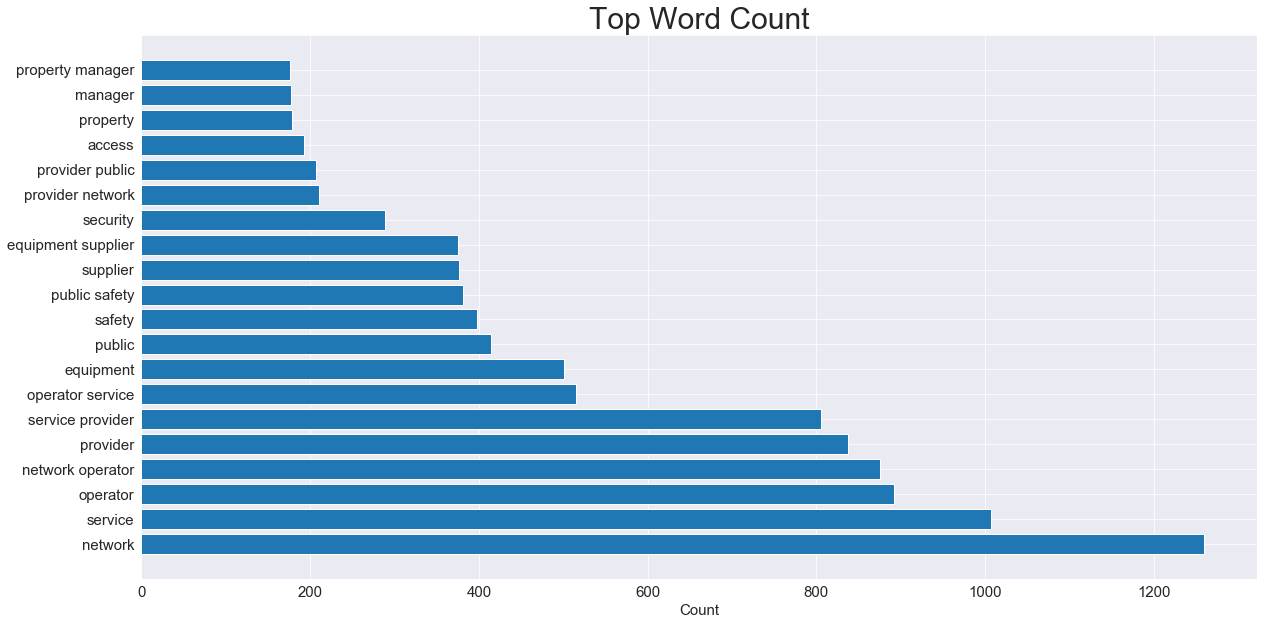

In [14]:
plt.figure(figsize = (20, 10))
plt.barh(y = cv_df_lem.sum().sort_values(ascending = False).head(20).index, width = cv_df_lem.sum().sort_values(ascending = False).head(20))
plt.title('Top Word Count', fontsize = 30)
plt.xlabel('Count', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

### Stemming

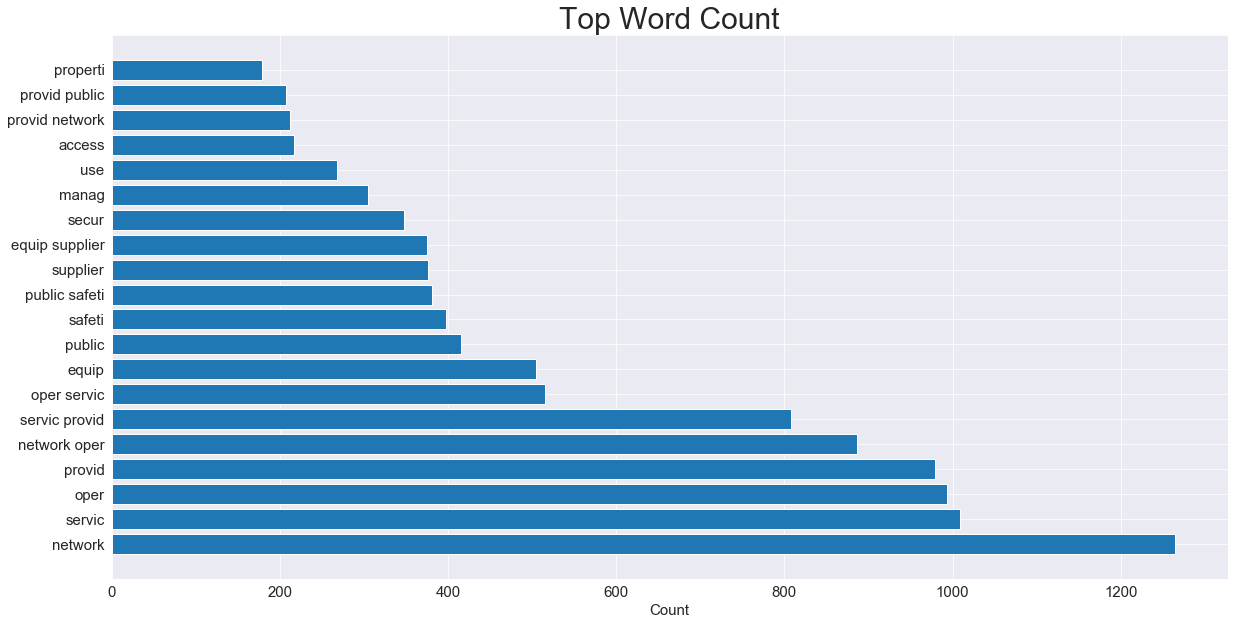

In [15]:
# This is the same thing we did above, but for stemmed words.
cv_stem = CountVectorizer(stop_words = 'english', ngram_range = (1,2), min_df = 25, max_df = .95)
cv_df_stem = pd.SparseDataFrame(cv_stem.fit_transform(processed['stemmed']), columns = cv_stem.get_feature_names())
cv_df_stem.fillna(0, inplace = True)

plt.figure(figsize = (20, 10))
plt.barh(y = cv_df_stem.sum().sort_values(ascending = False).head(20).index, width = cv_df_stem.sum().sort_values(ascending = False).head(20))
plt.title('Top Word Count', fontsize = 30)
plt.xlabel('Count', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

## Modeling: NLP to Determine Importance

In [16]:
english_stops = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')

really_important_tokens = [tokenizer.tokenize(i.lower()) for i in fcc_really_important['Description']]

clean_tokens = []
for i in really_important_tokens:
    clean_fcc_tokens = []
    for j in i:
        if j not in english_stops and j not in ['@','rt', 'https', 'com', 'network operators', 'property managers',
                                               'service providers', 'equipment suppliers', 'public safety'] and '@' not in j:
            clean_fcc_tokens.append(j)
    clean_tokens.append(clean_fcc_tokens)

In [17]:
vec_mod = gensim.models.KeyedVectors.load_word2vec_format('~/Desktop/GoogleNews-vectors-negative300.bin', binary = True)

In [18]:
###########################################################################################################
# HERE WE CREATE LISTS OF WORDS THAT WE THINK MAY INDICATE IMPORTANCE & ANOTHER LIST OF WORDS THAT        #
#... WE THINK MAYBE LIKELY TO APPEAR IN NON-THREATNING ATTACK.                                            #
#... WE WILL USE THESE LISTS OF WORDS TO CREATE VECTORS FOR Word2Vec COMPARISON IN THE NEXT FEW STEPS.    #
#... WE RECOMMEND USING SUBJECT MATTER EXPERTS TO DEVELOP APPROPRIATE WORD LISTS FOR THE GIVEN EVENT TYPE.#
###########################################################################################################

really_important = ['attack', 'malware', 'virus', 'worm', 'improve', 'performance', 'peer to peer', 'upgrades', 
                    'outages', 'measure', 'perform', 'affected', 'effected', 'wurm', 'spam', 'private', 'public',
                    'help', 'critical', 'highly important', 'trojan', 'infrastructure', 'network', 'security',
                    'telecommunications', 'routing', 'router', 'internet', 'modem', 'cable',
                    'cybersecurity', 'hardware', 'impacted', 'malicious', 'system', 'terrorist', 'natural disaster',
                    'electrical', 'restore', 'servers', 'end-users', 'major', 'disruptions', 'alert', 'impact',
                    'physical', 'digital', 'assets', 'harm', 'compromised', 'theft', 'penetration', 'deploy', 
                    'unauthorized', 'actors', 'rapidly', 'IP address', 'significant', 'danger', 'tracking', 'phishing',
                    'maleficence', 'impact', 'severity', 'permanent', 'software', 'protocols', 'espionage', 
                    'ransomware', 'spyware', 'black hat', 'hacking', 'denial of service', 'ddos', 'packets', 
                    'firewall']

not_important = ['help', 'philosophy', 'sociology', 'psychology', 'law', 'hurt', 'ethics', 'utilities', 'risk', 
                 'traffic', 'replacement', 'control', 'repairs', 'stabilization', 'remediation', 'signs', 'decking', 
                 'channel', 'prevention', 'building', 'mechanical', 'electrical', 'treatment', 'power', 'transmission', 
                 'restoration', 'inspection', 'assessment’, ‘port', 'insurance', 'temporary', 'spatial', 'temporal',
                 'block', 'broadcasters', 'wifi', 'bluetooth', 'service', 'policies', 'wireless', 'filtering', 
                 'engineering', 'maintenance', 'communications']

In [19]:
important_vect = np.zeros((1,300))
counter = 0
for word in really_important:
    if word not in vec_mod.vocab:
        continue
    else:
        temp = vec_mod.word_vec(word)
        important_vect = important_vect + temp
        counter += 1

important_vect = important_vect / counter
important_vect = np.squeeze(important_vect)

In [20]:
not_important_vect = np.zeros((1,300))
counter = 0
for word in not_important:
    if word not in vec_mod.vocab:
        continue
    else:
        temp = vec_mod.word_vec(word)
        not_important_vect = not_important_vect + temp
        counter += 1

not_important_vect = not_important_vect / counter
not_important_vect = np.squeeze(not_important_vect)

In [21]:
################################################################################################################
# THIS IS THE NLP STEP. THE LOOP WILL TURN EACH WORD IN YOUR LIST OF TOKENIZED DESCRIPTIONS (or                #
#... tokenized sentences) INTO A VECTOR, CLASSIFY THE WORD AS IMPORTANT OR NON-IMPORTANT USING COSINE          #
#... SIMILARITY & ASSIGN THE ENTIRE DESCRIPTION (or sentence) A VALUE BASED OFF OF THE BASELINE CLASSIFICATION #
#... SCORE.                                                                                                    #
################################################################################################################

fcc_target = [] # WE WILL FILL THIS WITH OUR CLASSIFICATIONS FOR EACH FULL DESCRIPTION
for words in clean_tokens:
    
    counter = 0
    for item in words:
        
        temp_vect = np.zeros((1, 300))
        if item not in vec_mod.vocab.keys(): # If word not Word2Vec model, do not include
            continue
        else:
            temp_vect = temp_vect + vec_mod.word_vec(item)
            counter += 1
    if counter == 0:
        counter = 1
    temp_vect = np.squeeze(temp_vect)/counter
        
        # THE BELOW STEP IS CALCULATING & COMPARING THE COSINE SIMILARITIES. THE DOT PRODUCT IS CALCULATED
        #... FOR THE DESCRIPTION VECTOR/THE IMPORTANT VECTOR & FOR THE DESCRIPTION VECTOR/NOT IMPORTANT
        #... VECTOR. AFTER CALCULATING THE DOT PRODUCT, WE DIVIDE BY THE ABS. VALUE OF THE TWO GIVEN VECTORS
        #... TO GET THE COSINE VALUE FOR THE ANGLE BETWEEN THE VECTORS. THE GREATER THE COSINE VALUE, THE CLOSER
        #... TWO VECTORS ARE TO ONE ANOTHER & DESCRIPTIONS ARE ASSIGNED A CLASSIFICATION OF IMPORTANCE OR NON-
        #... IMPORTANCE
    if np.dot(temp_vect, important_vect) / (np.linalg.norm(important_vect) * np.linalg.norm(temp_vect)) >= np.dot(temp_vect, not_important_vect) / (np.linalg.norm(not_important_vect) * np.linalg.norm(temp_vect)):
        fcc_target.append(2)
    else:
        fcc_target.append(1)
        

In [22]:
# Set the labels of the on-topic descriptions to 1 for not important & 2 for important.
fcc_really_important['label'] = fcc_target

# Combine the on-topic urgent/non-urgent tweets with the off-topic tweets
fcc_csv = pd.concat([fcc_really_important, fcc_not_important])

fcc_csv.sort_index(inplace = True)

fcc_really_important['label'].value_counts()

1    303
2    245
Name: label, dtype: int64

## Modeling: Logisitic Regression

In [23]:
processed.columns

Index(['BP Number', 'Priority', 'Description', 'Network Type(s)',
       'Industry Role(s)', 'Keywords', 'Reference', 'cable', 'internet/Data',
       'satellite', 'wireless', 'wireline', 'Service Provider',
       'Network Operator', 'Priorities', 'Equipment Supplier',
       'Property Manager', 'Government', 'Public Safety', 'tokenized',
       'lemmatized', 'stemmed'],
      dtype='object')

In [24]:
processed['Priorities'].value_counts()

1    548
0    468
Name: Priorities, dtype: int64

In [25]:
X = processed['tokenized']
y = processed['Priorities']

In [26]:
y.value_counts(normalize = True)

1    0.53937
0    0.46063
Name: Priorities, dtype: float64

In [27]:
tf = TfidfVectorizer(stop_words = 'english', ngram_range = (1, 2), max_df = .95, min_df = 25)
X_tf = tf.fit_transform(X)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size = 0.3, stratify = y)

In [29]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
lr.score(X_train, y_train)

0.7187060478199718

In [31]:
lr.score(X_test, y_test)

0.659016393442623

In [32]:
mnb = MultinomialNB()
mnb_grid = {}
gs_mnb = GridSearchCV(mnb, param_grid = mnb_grid, cv = 5)
gs_mnb.fit(X_train, y_train)
gs_mnb.score(X_train, y_train)

0.6933895921237694

In [33]:
gs_mnb.score(X_test, y_test)

0.6655737704918033

In [34]:
model = Sequential()

n_input = X_train.shape[1]

model.add(Dense(18, input_dim = n_input, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer = regularizers.l2(0.01)))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = None)

W0825 17:17:45.182537 4651242944 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 17:17:45.741938 4651242944 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 17:17:45.954389 4651242944 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 17:17:46.097637 4651242944 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0825 17:17:46.129389 4651242944 deprecation_wrapper.py:119] From /anaconda3

Train on 711 samples, validate on 305 samples
Epoch 1/100
711/711 [==============================] - 2s 3ms/step - loss: 0.9782 - acc: 0.5373 - val_loss: 0.9277 - val_acc: 0.5508
Epoch 2/100
711/711 [==============================] - 0s 58us/step - loss: 0.8936 - acc: 0.5752 - val_loss: 0.8569 - val_acc: 0.5738
Epoch 3/100
711/711 [==============================] - 0s 59us/step - loss: 0.8318 - acc: 0.5752 - val_loss: 0.8055 - val_acc: 0.5770
Epoch 4/100
711/711 [==============================] - 0s 58us/step - loss: 0.7874 - acc: 0.5682 - val_loss: 0.7694 - val_acc: 0.5770
Epoch 5/100
711/711 [==============================] - 0s 58us/step - loss: 0.7565 - acc: 0.5767 - val_loss: 0.7440 - val_acc: 0.5869
Epoch 6/100
711/711 [==============================] - 0s 57us/step - loss: 0.7348 - acc: 0.5584 - val_loss: 0.7261 - val_acc: 0.5639
Epoch 7/100
711/711 [==============================] - 0s 57us/step - loss: 0.7197 - acc: 0.5471 - val_loss: 0.7137 - val_acc: 0.5541
Epoch 8/100
711/7

711/711 [==============================] - 0s 51us/step - loss: 0.6873 - acc: 0.6329 - val_loss: 0.6886 - val_acc: 0.6066
Epoch 62/100
711/711 [==============================] - 0s 54us/step - loss: 0.6869 - acc: 0.6273 - val_loss: 0.6886 - val_acc: 0.5902
Epoch 63/100
711/711 [==============================] - 0s 58us/step - loss: 0.6873 - acc: 0.6020 - val_loss: 0.6889 - val_acc: 0.6066
Epoch 64/100
711/711 [==============================] - 0s 65us/step - loss: 0.6869 - acc: 0.6076 - val_loss: 0.6887 - val_acc: 0.5967
Epoch 65/100
711/711 [==============================] - 0s 56us/step - loss: 0.6873 - acc: 0.6287 - val_loss: 0.6890 - val_acc: 0.6066
Epoch 66/100
711/711 [==============================] - 0s 61us/step - loss: 0.6872 - acc: 0.6357 - val_loss: 0.6891 - val_acc: 0.6033
Epoch 67/100
711/711 [==============================] - 0s 58us/step - loss: 0.6870 - acc: 0.6188 - val_loss: 0.6890 - val_acc: 0.5934
Epoch 68/100
711/711 [==============================] - 0s 58us/step

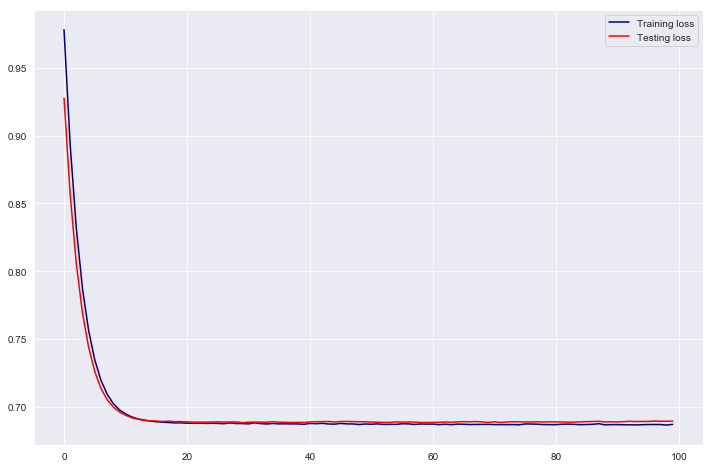

In [35]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize = (12, 8))
plt.plot(train_loss, label = 'Training loss', color = 'navy')
plt.plot(test_loss, label = 'Testing loss', color = 'Red')
plt.legend();

In [36]:
history.history['acc'][-1], history.history['val_acc'][-1]

(0.63994374125148, 0.6032786896971406)

In [37]:
model_dropout = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input

model_dropout.add(Dense(n_hidden, input_dim = n_input, activation = 'relu'))
model_dropout.add(Dropout(0.5)) # refers to nodes in the first hidden layer
model_dropout.add(Dense(1, activation = 'sigmoid'))

model_dropout.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

history_dropout = model_dropout.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = None)

W0825 17:17:53.419301 4651242944 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 711 samples, validate on 305 samples
Epoch 1/100
711/711 [==============================] - 1s 780us/step - loss: 0.6954 - acc: 0.4838 - val_loss: 0.6867 - val_acc: 0.5443
Epoch 2/100
711/711 [==============================] - 0s 74us/step - loss: 0.6808 - acc: 0.5724 - val_loss: 0.6786 - val_acc: 0.5836
Epoch 3/100
711/711 [==============================] - 0s 76us/step - loss: 0.6667 - acc: 0.6160 - val_loss: 0.6721 - val_acc: 0.5967
Epoch 4/100
711/711 [==============================] - 0s 76us/step - loss: 0.6530 - acc: 0.6343 - val_loss: 0.6632 - val_acc: 0.6230
Epoch 5/100
711/711 [==============================] - 0s 77us/step - loss: 0.6424 - acc: 0.6948 - val_loss: 0.6551 - val_acc: 0.6590
Epoch 6/100
711/711 [==============================] - 0s 76us/step - loss: 0.6296 - acc: 0.6892 - val_loss: 0.6449 - val_acc: 0.6689
Epoch 7/100
711/711 [==============================] - 0s 77us/step - loss: 0.6185 - acc: 0.6807 - val_loss: 0.6361 - val_acc: 0.6656
Epoch 8/100
711

711/711 [==============================] - 0s 72us/step - loss: 0.2060 - acc: 0.9536 - val_loss: 0.6892 - val_acc: 0.6820
Epoch 62/100
711/711 [==============================] - 0s 73us/step - loss: 0.2048 - acc: 0.9606 - val_loss: 0.6938 - val_acc: 0.6754
Epoch 63/100
711/711 [==============================] - 0s 79us/step - loss: 0.2032 - acc: 0.9550 - val_loss: 0.6926 - val_acc: 0.6820
Epoch 64/100
711/711 [==============================] - 0s 70us/step - loss: 0.1922 - acc: 0.9705 - val_loss: 0.6939 - val_acc: 0.6820
Epoch 65/100
711/711 [==============================] - 0s 69us/step - loss: 0.1894 - acc: 0.9620 - val_loss: 0.6997 - val_acc: 0.6754
Epoch 66/100
711/711 [==============================] - 0s 70us/step - loss: 0.1934 - acc: 0.9592 - val_loss: 0.7065 - val_acc: 0.6754
Epoch 67/100
711/711 [==============================] - 0s 75us/step - loss: 0.1861 - acc: 0.9550 - val_loss: 0.7078 - val_acc: 0.6656
Epoch 68/100
711/711 [==============================] - 0s 82us/step

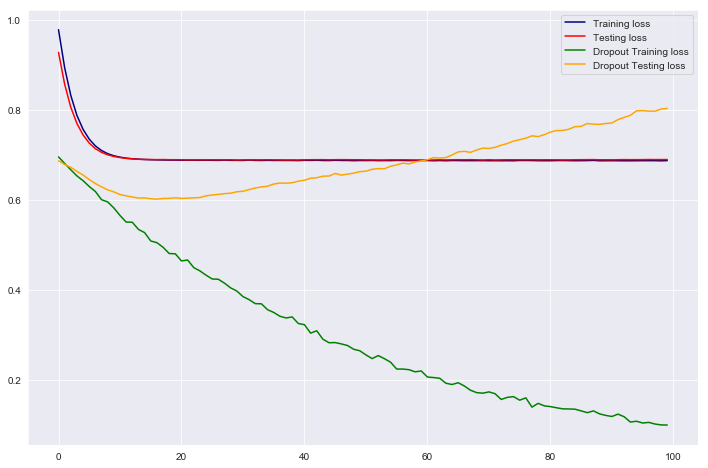

In [38]:
train_loss_dropout = history_dropout.history['loss']
test_loss_dropout = history_dropout.history['val_loss']
plt.figure(figsize = (12, 8))
plt.plot(train_loss, label = 'Training loss', color = 'navy')
plt.plot(test_loss, label = 'Testing loss', color = 'red')
plt.plot(train_loss_dropout, label = 'Dropout Training loss', color = 'green')
plt.plot(test_loss_dropout, label = 'Dropout Testing loss', color = 'orange')
plt.legend();

In [39]:
history_dropout.history['acc'][-1], history_dropout.history['val_acc'][-1]

(0.9831223628691983, 0.6721311481272588)

In [45]:
pred = model.predict
pred

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x26a733710>>